In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
print(os.getcwd())

/content


In [3]:
cd /content/drive/MyDrive/Dacon/Prediction_of_lymph_node_metastasis_in_breast_cancer/Dataset

/content/drive/.shortcut-targets-by-id/1BGb1VxGOMWBMoHmaLCndCLhwPauqrnRZ/Prediction_of_lymph_node_metastasis_in_breast_cancer/Dataset


In [4]:
pwd

'/content/drive/.shortcut-targets-by-id/1BGb1VxGOMWBMoHmaLCndCLhwPauqrnRZ/Prediction_of_lymph_node_metastasis_in_breast_cancer/Dataset'

In [5]:
import random
import pandas as pd
import numpy as np
import os
import cv2
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader,TensorDataset

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torchvision.models as models

from sklearn import metrics
from sklearn.preprocessing import StandardScaler, LabelEncoder

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings(action='ignore') 

import matplotlib.pyplot as plt


from PIL import Image, ImageDraw, ImageFont

torch.backends.cudnn.enabled = False
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

%load_ext autoreload
%autoreload 2
%matplotlib inline
warnings.filterwarnings("ignore")
%config InlineBackend.figure_format = 'retina'

#Data Pre-processing

In [6]:
train_df = pd.read_csv('/content/drive/MyDrive/Dacon/data/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Dacon/data/test.csv')

In [7]:
train_df['암의 장경'] = train_df['암의 장경'].fillna(train_df['암의 장경'].mean())
train_df = train_df.fillna(0)

test_df['암의 장경'] = test_df['암의 장경'].fillna(train_df['암의 장경'].mean())
test_df = test_df.fillna(0)

In [8]:
train_df = train_df.drop(columns=['mask_path','DCIS_or_LCIS_type','HER2_IHC','HER2_SISH','HER2_SISH_ratio','BRCA_mutation','ID', 'img_path', '수술연월일'])
test_df = test_df.drop(columns=['DCIS_or_LCIS_type','HER2_IHC','HER2_SISH','HER2_SISH_ratio','BRCA_mutation','ID', 'img_path', '수술연월일'])

In [9]:
train_df.head()

,나이,진단명,암의 위치,암의 개수,암의 장경,NG,HG,HG_score_1,HG_score_2,HG_score_3,DCIS_or_LCIS_여부,T_category,ER,ER_Allred_score,PR,PR_Allred_score,KI-67_LI_percent,HER2,N_category
0,63,1,2,1,19.000000,2.0,1.0,2.0,2.0,1.0,2,1.0,1.0,8.0,1.0,6.0,12.0,0.0,0
1,51,1,1,1,22.000000,3.0,3.0,3.0,3.0,3.0,0,2.0,0.0,0.0,0.0,0.0,70.0,0.0,1
2,37,1,2,1,18.375564,2.0,0.0,0.0,0.0,0.0,1,0.0,1.0,7.0,1.0,4.0,7.0,0.0,0
3,54,1,2,1,0.000000,3.0,3.0,3.0,3.0,2.0,1,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0
4,57,1,2,1,8.000000,2.0,2.0,3.0,2.0,1.0,2,1.0,1.0,8.0,0.0,0.0,8.0,1.0,0


In [10]:
test_df.head()

,나이,진단명,암의 위치,암의 개수,암의 장경,NG,HG,HG_score_1,HG_score_2,HG_score_3,DCIS_or_LCIS_여부,T_category,ER,ER_Allred_score,PR,PR_Allred_score,KI-67_LI_percent,HER2
0,55,2,2,1,23.000000,2.0,2.0,3.0,2.0,1.0,0,2.0,1.0,8.0,0.0,2.0,5.00,0.0
1,43,4,2,1,13.000000,3.0,2.0,2.0,3.0,1.0,2,1.0,1.0,4.0,1.0,8.0,8.67,0.0
2,76,1,1,1,18.375564,0.0,0.0,0.0,0.0,0.0,1,0.0,1.0,6.0,1.0,6.0,0.00,0.0
3,58,1,2,1,1.300000,2.0,2.0,3.0,2.0,1.0,2,1.0,1.0,7.0,0.0,0.0,21.17,1.0
4,56,1,2,2,15.000000,3.0,3.0,3.0,3.0,2.0,2,1.0,1.0,8.0,1.0,3.0,20.57,1.0


In [11]:
def data_to_image(data):
    data_images = []
    font = ImageFont.truetype('/content/drive/MyDrive/Dacon/JjzoJe3v0Y1GrvtqZaC2DofdiS8.ttf',size=50)
    for dat in data:
        background = np.array([[0 for _ in range(255)] for _ in range(255)], dtype='uint8')
        image = Image.fromarray(background)
        draw = ImageDraw.Draw(image)
        draw.text((32, 32), str(dat[0]), fill='white', font=font)
        draw.text((32, 160), str(dat[1]), fill='white', font=font)
        draw.text((160, 32), str(dat[2]), fill='white', font=font)
        draw.text((160, 160), str(dat[3]), fill='white', font=font)
        rgb = [np.array(image, dtype='uint8') for _ in range(3)]
        data_images.append(rgb)
    return np.array(data_images) / 255

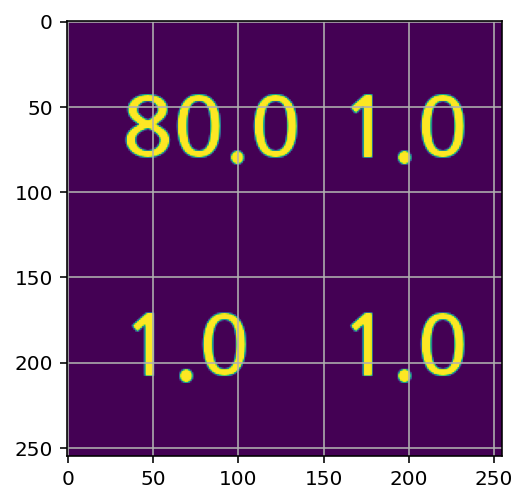

In [12]:
X_train, X_val, y_train, y_val = train_test_split(train_df.drop(columns=['N_category']), train_df['N_category'], stratify=train_df['N_category'], test_size=0.2, random_state=0)

X_train = np.array(X_train)
X_val = np.array(X_val)
 
y_train = np.array(y_train)
y_val = np.array(y_val)

train_images = data_to_image(X_train)
val_images = data_to_image(X_val)

plt.grid()
plt.imshow(train_images[0][0, :, :])

In [13]:
X_train = torch.from_numpy(train_images).float()
y_train = torch.from_numpy(y_train).double()#.float()
X_val = torch.from_numpy(val_images).float()
y_val = torch.from_numpy(y_val).double()#.float()

train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

dataloaders = {'train': DataLoader(train_dataset, batch_size=32, shuffle=True),
              'val': DataLoader(val_dataset)}

dataset_sizes = {'train': len(X_train),
                 'val': len(X_val)}

In [17]:
model = models.resnet50().to(device)#.efficientnet_b6().to(device)
#num_features = model.fc.in_features
model.classifier = nn.Linear(2304, 1)

criterion = nn.BCEWithLogitsLoss()

optimizer = optim.Adam(model.parameters())
print(model)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 56, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(56, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(56, 56, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=56, bias=False)
            (1): BatchNorm2d(56, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(56, 14, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(14, 56, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormAct

In [18]:
import copy
import time

import torch

def train_model(model, dataloaders, dataset_sizes, criterion, optimizer, device, epochs=20):
    start = time.time()
    
    best_model_weights = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(epochs):
        print("EPOCH {} / {}: ".format(epoch+1, epochs))
        print("-" * 10)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            batch_loss = 0.0
            batch_corrects = 0
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                #inputs = inputs.view(-1)
                labels = labels.to(device)
                labels = labels.view(-1,1)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase =='train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                batch_loss += loss.item() * inputs.size(0)
                batch_corrects += torch.sum(preds == labels.data)
        
        epoch_loss = batch_loss / dataset_sizes[phase]
        epoch_acc = batch_corrects.double() / dataset_sizes[phase]
        
        print("{} Loss: {:.4f} Acc: {: .4f}".format(phase, epoch_loss, epoch_acc))
        
        if phase == 'val' and epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_weights = copy.deepcopy(model.state_dict())
            
    end = time.time()
    elapsed_time = end - start
    print("Training COMPLETED: {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    print("BEST VALIDATION ACCURACY: {:4f}".format(best_acc))
    
    model.load_state_dict(best_model_weights)
    return model

In [19]:
best_model = train_model(model, dataloaders, dataset_sizes, criterion, optimizer, device, epochs=20)

EPOCH 1 / 20: 
----------
val Loss: 0.6932 Acc:  0.4850
EPOCH 2 / 20: 
----------
val Loss: 0.6928 Acc:  0.4850
EPOCH 3 / 20: 
----------
val Loss: 0.6930 Acc:  0.4850
EPOCH 4 / 20: 
----------
val Loss: 0.6932 Acc:  0.4850
EPOCH 5 / 20: 
----------
val Loss: 0.6933 Acc:  0.4850
EPOCH 6 / 20: 
----------
val Loss: 0.6930 Acc:  0.4850
EPOCH 7 / 20: 
----------
val Loss: 0.6934 Acc:  0.4850
EPOCH 8 / 20: 
----------
val Loss: 0.6929 Acc:  0.4850
EPOCH 9 / 20: 
----------
val Loss: 0.6932 Acc:  0.4850
EPOCH 10 / 20: 
----------
val Loss: 0.6933 Acc:  0.4850
EPOCH 11 / 20: 
----------
val Loss: 0.6955 Acc:  0.4850
EPOCH 12 / 20: 
----------
val Loss: 0.6933 Acc:  0.4850
EPOCH 13 / 20: 
----------
val Loss: 0.6948 Acc:  0.4850
EPOCH 14 / 20: 
----------
val Loss: 0.6938 Acc:  0.4850
EPOCH 15 / 20: 
----------
val Loss: 0.6947 Acc:  0.4850
EPOCH 16 / 20: 
----------
val Loss: 0.6943 Acc:  0.4850
EPOCH 17 / 20: 
----------
val Loss: 0.6954 Acc:  0.4850
EPOCH 18 / 20: 
----------
val Loss: 0.6

In [ ]:
test_dataset = dataloaders(test_df, None)#, test_transforms)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=0)

In [ ]:
def inference(model, test_loader, device):
    model.to(device)
    model.eval()
    preds = []
    threshold = 0.5
    
    with torch.no_grad():
        for img, tabular in tqdm(iter(test_loader)):
            #img = img.float().to(device)
            tabular = tabular.float().to(device)
            
            #model_pred = model(img, tabular)
            model_pred = model(tabular)
            model_pred = model_pred.squeeze(1).to('cpu')
            
            preds += model_pred.tolist()
    
    preds = np.where(np.array(preds) > threshold, 1, 0)
    
    return preds

In [ ]:
preds = inference(best_model, test_loader, device)

In [ ]:
submit = pd.read_csv('./sample_submission.csv')

In [ ]:
submit['N_category'] = preds
submit.to_csv('/content/drive/MyDrive/Dacon/SuperTML_submit.csv', index=False)